In [6]:
import torch
import numpy as np
import pickle
from torch.utils.data import Dataset
from train import Net
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from train import Net
from torch.utils.data import Dataset
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from cautious_extrapolation.data_paths import DATA_PATHS
from cautious_extrapolation.utils import get_imagenet_features

In [7]:
model = Net().to("cuda")
model.load_state_dict(torch.load(os.path.join("data", "model1.pt")))
model.eval()
model.cuda()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [10]:
class P_MNIST(Dataset):
    def __init__(self, perturbed_imgs, labels, transform=None):
        self.transform = transform
        self.imgs = perturbed_imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [8]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

test_dataset = datasets.MNIST(DATA_PATHS["desktop"]["MNIST"], train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024)

In [11]:
file = open(os.path.join("data", "perturbed_ds_10.pkl"),'rb')
data = pickle.load(file)
file.close()
p_data_loader = torch.utils.data.DataLoader(P_MNIST(data["image"].astype(float), data["label"]), batch_size=1024)

In [12]:

inputs = np.zeros((len(test_dataset)))
phis_conv1 = np.zeros((len(test_dataset)))
phis_conv2 = np.zeros((len(test_dataset)))
phis_fc1 = np.zeros((len(test_dataset)))
phis_fc2 = np.zeros((len(test_dataset)))
accuracies = np.zeros((len(test_dataset)))
entropies = np.zeros((len(test_dataset)))

for batch_idx, (data, target) in enumerate(test_loader):
    x, target = data.cuda().float(), target.cuda()
    inputs[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(np.reshape(x.cpu().detach().numpy(), (len(x), -1)), axis=1)
    x = model.conv1(x)
    out = x -  model.conv1._parameters["bias"].unsqueeze(0).unsqueeze(2).unsqueeze(3)
    phis_conv1[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(np.reshape(out.cpu().detach().numpy(), (len(out), -1)), axis=1)

    x = F.relu(x)
    x = model.conv2(x)
    out = x -  model.conv2._parameters["bias"].unsqueeze(0).unsqueeze(2).unsqueeze(3)
    phis_conv2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(np.reshape(out.cpu().detach().numpy(), (len(out), -1)), axis=1)

    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)

    x = model.fc1(x)
    out = x - model.fc1._parameters["bias"].unsqueeze(0)
    phis_fc1[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(out.cpu().detach().numpy(), axis=1)

    x = F.relu(x)
    x = model.fc2(x)
    out = x - model.fc2._parameters["bias"].unsqueeze(0)
    phis_fc2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(out.cpu().detach().numpy(), axis=1)

    x = F.log_softmax(x, dim=1)

    accuracies[batch_idx*1024:(batch_idx+1)*1024] = np.argmax(x.cpu().detach().numpy(), axis=1) == target.cpu().detach().numpy()
    entropies[batch_idx*1024:(batch_idx+1)*1024] = -np.sum(np.exp(x.cpu().detach().numpy())*x.cpu().detach().numpy(), axis=1)

In [14]:

inputs_2 = np.zeros((len(test_dataset)))
phis_conv1_2 = np.zeros((len(test_dataset)))
phis_conv2_2 = np.zeros((len(test_dataset)))
phis_fc1_2 = np.zeros((len(test_dataset)))
phis_fc2_2 = np.zeros((len(test_dataset)))
accuracies_2 = np.zeros((len(test_dataset)))
entropies_2 = np.zeros((len(test_dataset)))

for batch_idx, (data, target) in enumerate(p_data_loader):
    x, target = data.cuda().float(), target.cuda()
    inputs_2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(np.reshape(x.cpu().detach().numpy(), (len(x), -1)), axis=1)
    x = model.conv1(x)
    out = x -  model.conv1._parameters["bias"].unsqueeze(0).unsqueeze(2).unsqueeze(3)
    phis_conv1_2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(np.reshape(out.cpu().detach().numpy(), (len(out), -1)), axis=1)

    x = F.relu(x)
    x = model.conv2(x)
    out = x -  model.conv2._parameters["bias"].unsqueeze(0).unsqueeze(2).unsqueeze(3)
    phis_conv2_2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(np.reshape(out.cpu().detach().numpy(), (len(out), -1)), axis=1)

    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)

    x = model.fc1(x)
    out = x - model.fc1._parameters["bias"].unsqueeze(0)
    phis_fc1_2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(out.cpu().detach().numpy(), axis=1)

    x = F.relu(x)
    x = model.fc2(x)
    out = x - model.fc2._parameters["bias"].unsqueeze(0)
    phis_fc2_2[batch_idx*1024:(batch_idx+1)*1024] = np.linalg.norm(out.cpu().detach().numpy(), axis=1)

    x = F.log_softmax(x, dim=1)

    accuracies_2[batch_idx*1024:(batch_idx+1)*1024] = np.argmax(x.cpu().detach().numpy(), axis=1) == target.cpu().detach().numpy()
    entropies_2[batch_idx*1024:(batch_idx+1)*1024] = -np.sum(np.exp(x.cpu().detach().numpy())*x.cpu().detach().numpy(), axis=1)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  import sys


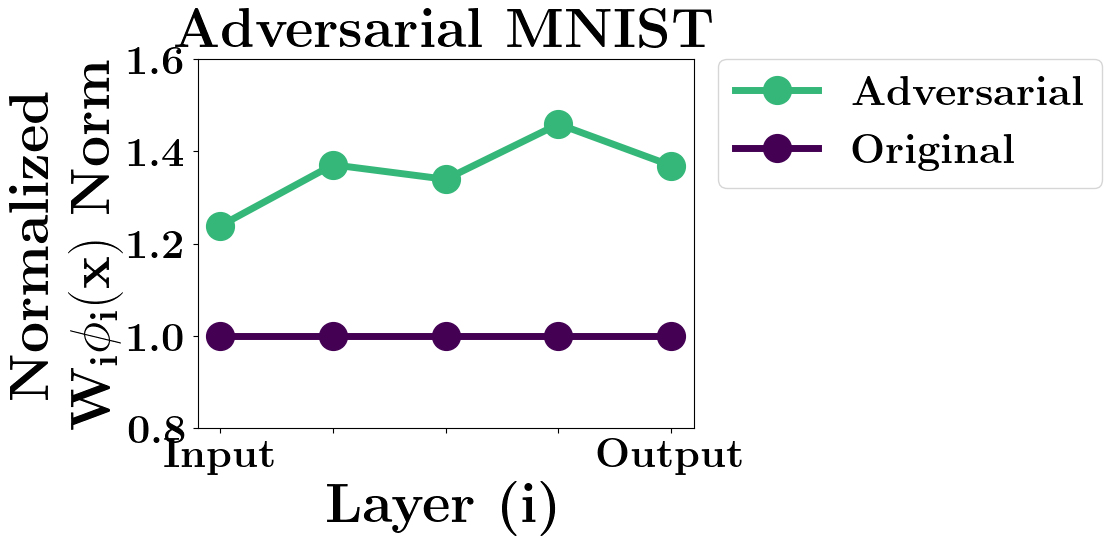

In [39]:
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

viridis = cm.get_cmap('viridis', 4)

colors = viridis(range(4))
plt.plot([inputs_2.mean()/inputs.mean(), phis_conv1_2.mean()/phis_conv1.mean(), phis_conv2_2.mean()/phis_conv2.mean(), phis_fc1_2.mean()/phis_fc1.mean(), phis_fc2_2.mean()/phis_fc2.mean()],  "o-", linewidth=5, markersize=20, c=colors[2], label = r"\textbf{Adversarial}")
plt.plot([1, 1, 1, 1, 1],  "o-", linewidth=5, markersize=20, c=colors[0], label = r"\textbf{Original}")

plt.ylim(0.8, 1.6)
plt.xticks([0, 1, 2, 3, 4], [r"\textbf{Input}", "", "", "", r"\textbf{Output}"])
plt.yticks([0.8, 1, 1.2, 1.4, 1.6], [r"\textbf{0.8}", r"\textbf{1.0}", r"\textbf{1.2}", r"\textbf{1.4}", r"\textbf{1.6}"])
plt.tick_params(axis='both', which='major', labelsize=30)
plt.xlabel(r"\textbf{Layer (i)}", fontsize=40)
plt.ylabel(r"\textbf{Normalized"+"\n"+r"$\mathbf{W_i \phi_i(x)}$"+r"\textbf{ Norm}", fontsize=40)
plt.title(r"\textbf{Adversarial MNIST}", fontsize=40)

#put legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=30)